# Alpha Zero

This project is about developing my own chess AI using PyTorch.  
While gathering information, Robert Förster's course on YouTube (https://www.youtube.com/watch?v=wuSQpLinRB4) has been very informative and inspired me to getting starting with RL.


## Importing libraries


In [1]:
%pip install gym==0.17.2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

                                              0.0/1.6 MB ? eta -:--:--
                                              0.0/1.6 MB ? eta -:--:--
     -                                        0.1/1.6 MB 825.8 kB/s eta 0:00:02
     -                                        0.1/1.6 MB 825.8 kB/s eta 0:00:02
     --                                       0.1/1.6 MB 656.4 kB/s eta 0:00:03
     ---                                      0.1/1.6 MB 554.9 kB/s eta 0:00:03
     ---                                      0.1/1.6 MB 554.9 kB/s eta 0:00:03
     ----                                     0.2/1.6 MB 492.3 kB/s eta 0:00:03
     ----                                     0.2/1.6 MB 535.8 kB/s eta 0:00:03
     ------                                   0.2/1.6 MB 576.2 kB/s eta 0:00:03
     -------                                  0.3/1.6 MB 632.7 kB/s eta 0:00:03

In [2]:
import numpy as np
print(np.__version__)

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

import matplotlib.pyplot as plt

from tqdm.notebook import trange

import random
import math

1.23.5
2.0.1+cu117


## Create a game

The game must have following properties / methods:

- <b>row_count:</b> return the number of rows of the board
- <b>column_count:</b> return the number of columns of the board
- <b>action_size:</b> return the actions which can be taken at the board (TicTacToe: row_count \* column_count)
- <b>get_initial_state():</b> return the board at the beginning of the game
- <b>get_next_state(state, action, player):</b> make a move and update the board
- <b>get_valid_moves(state):</b> return all possible moves at the current state
- <b>check_win(state, action):</b> check if an action at a current state results in a win
- <b>get_value_and_terminated(state, action):</b> check if the game has ended in some way (lose, draw, win)
- <b>get_opponent(player):</b> get the opponent player
- <b>get_opponent_value(player):</b> get the value of the opponent player
- <b>change_perspective(state, player):</b> change the perspective of the board (e.g. state \* player)
- <b>get_encoded_state(state):</b> return a encoded version of the current state


In [10]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def __repr__(self):
        return "TicTacToe"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True # this action ended the game with a win for the player who took this action
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True # this action ended the game but the players drew
        return 0, False # the game has not ended yet
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        # check if batch dim exists
        # if exists then correct the order
        if len(state.shape) == 3: 
            encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state

In [5]:
class ConnectFour:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4
        
    def __repr__(self):
        return "ConnectFour"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0 
                    or r >= self.row_count
                    or c < 0 
                    or c >= self.column_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1

        return (
            count(1, 0) >= self.in_a_row - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1 # top right diagonal
        )
    
        
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True # this action ended the game with a win for the player who took this action
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True # this action ended the game but the players drew
        return 0, False # the game has not ended yet
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        # check if batch dim exists
        # if exists then correct the order
        if len(state.shape) == 3: 
            encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state

In [3]:
import chess
import gym, gym_chess
import lib.move_encoding.functions as environment
from lib.move_encoding.utils import rotate

class Chess:
    def __init__(self):
        self.row_count = 8
        self.column_count = 8
        self.env = environment.MoveEncoding(gym.make('ChessAlphaZero-v0'))
        self.action_size = self.env.action_space.n
    
    def __repr__(self):
        return "Chess"

    def get_initial_state(self):
        self.env.reset()
        return chess.Board()
    
    def move_to_action(self, move, state):
        return self.env.encode(move, state)

    def action_to_move(self, action, state):
        return self.env.decode(action, state)

    # state equals board
    def get_next_state(self, state, action, player):
        move = self.action_to_move(action, state)
        state.push(move)
        return state

        
    def get_valid_moves(self, state):
        legal_moves = np.zeros(self.action_size)
        for move in state.legal_moves:
            n_move = self.move_to_action(move, state)
            legal_moves[n_move] = 1
        return legal_moves
    
    def check_win(self, state, action):
        if action == None:
            return False
        return state.is_checkmate()
    
        
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True # this action ended the game with a win for the player who took this action
        if state.is_stalemate() or state.is_insufficient_material() or state.can_claim_fifty_moves() or state.can_claim_threefold_repetition():
            return 0, True # this action ended the game but the players drew
        return 0, False # the game has not ended yet
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state
    
    
    # Channels 0-5: White pieces (Pawn, Knight, Bishop, Rook, Queen, King).
    # Channels 6-11: Black pieces (Pawn, Knight, Bishop, Rook, Queen, King).
    # Channel 12: Side to move (1 for white, 0 for black).
    # Channel 13-14: Castling rights for white (kingside, queenside).
    # Channel 15-16: Castling rights for black (kingside, queenside).
    # Channel 17: Potential en passant square (encoded as a binary matrix with a 1 on the potential en passant square, if any).
    def get_encoded_state(self, state):
       # Create an 8x8x18 feature plane
        encoded_state = np.zeros((18, 8, 8), dtype=np.float32)
        # Iterate through each square on the board
        for row in range(8):
            for col in range(8):
                square = chess.square(col, 7 - row)  # Flip the row for the correct orientation
                piece = state.piece_at(square)
                if piece is not None:
                    piece_index = chess.PIECE_TYPES.index(piece.piece_type)
                    color_index = int(piece.color)
                    channel = piece_index + color_index * 6  # 6 channels per piece type
                    encoded_state[channel, row, col] = 1

        # Encode side to move
        encoded_state[12, :, :] = 1 if state.turn == chess.WHITE else 0
        
        # Encode castling rights
        encoded_state[13, :, :] = int(state.has_kingside_castling_rights(chess.WHITE))
        encoded_state[14, :, :] = int(state.has_queenside_castling_rights(chess.WHITE))
        encoded_state[15, :, :] = int(state.has_kingside_castling_rights(chess.BLACK))
        encoded_state[16, :, :] = int(state.has_queenside_castling_rights(chess.BLACK))

        # Encode potential en passant square
        if state.ep_square is not None:
            row, col = 7 - state.ep_square // 8, state.ep_square % 8  # Extracting row, col from square number
            encoded_state[17, row, col] = 1

        # check if batch dim exists
        # if exists then correct the order
        # if len(state.shape) == 4: 
        #    encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state        



## Designing of a model

Here a ResNet model has been chosen, containing of multiple Conv2D Layers which can find patterns in 2d games like TicTacToe or chess.  
The ResNet has following layers:

- 1 x startblock
- n x backbone (here the input will be additionally added to the output)
- 1 x policyhead (returns policy values as a linear layer)
- 1 x valuehead (returns value in range -1 and 1 (by using tanh))


In [4]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, num_channels, device):
        super().__init__()
        
        self.device = device
        # combination of kernel_size=3, padding=1 and stride=1 important => guarantees that input_shape = output_shape  
        # e.g.: 5x5 image with 3x3 convolution results in a 3x3 output => padding 1 in all directions results in a 5x5 output
        # therefore the shape of the image stays consistant during the computations
        self.startBlock = nn.Sequential(
            nn.Conv2d(num_channels, num_hidden, kernel_size=3, padding=1), 
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
    

        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

## Updated MCTS Implementation

Using the Monte Carlo Tree Search algorithm enables splitting the game of choice in many different paths of action and their probability of success.  
Therefore it is perfect for solving a game tree in games like chess or TicTacToe.  
It contains of four phases:

- <u>Selection:</u> Walking down until a leaf node has been found (leaf node is a node that could be expanded even further)  
   The path is determined by the UCB-fomular (a node is chosen which has a higher winning prob and lower visit counts)
- <u>Expansion:</u> When reached a leaf node in the selection phase, new leaf node(s) will be created, which are attached at the current node  
   The number of leaf nodes are equal to the number of valid moves
- <u>Simulation:</u> Simulate the game by either random choices or like in the updated version, by using a neural network
- <u>Backpropagation:</u> Update the tree from the bottom to the top (until root node is reached)


In [5]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state # current state of the game
        self.parent = parent # the parent node
        self.action_taken = action_taken # the action which has to be taken to arrive at this node 
        self.prior = prior # is the policy value the model provided us 
        
        self.children = [] # list of all child nodes
        
        self.visit_count = visit_count # the count of all visits to this node
        self.value_sum = 0 # the current sum of all simulations (of the neural network)
    
    # check if current node has child nodes
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    # returns the child node with the highest ucb score during selection phase
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    # calculate the ucb value of a child node
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            # 1 - ()  because we want to have the opponent in the worst possible situation in the next move
            # ( +1) / 2 because we want a proablilty and not some negative values which could occur in this implementation
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    # expanding the tree in all possible directions (all valid moves own a child node)
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                # we are always player 1 - we just change the states 
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

    # update the whole tree (all parant nodes beginning from current node)
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    # this is the above explained sequence the mcts algorithm has to follow  
    @torch.no_grad() # not updating the gradiants when calling this function => no training or updating the model here 
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        
        # the first pass-through is slightly different => adding noice (temperatur) to explore more
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        # deleting invalid moves and renormalizing before expanding
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            # run until leaf node is found
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminated = self.game.get_value_and_terminated(node.state, node.action_taken)
            # action_taken is here the action taken by the opponent => if value says we won -> opponent won
            value = self.game.get_opponent_value(value)
            
            if not is_terminated:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
        # get the most promising child out of all root children
        # => the child with the most visit_counts is the most promising 
        # because of how the ucb-formular works 
        # (after many simulations the one with the highest visit count usually 
        #   aligns with the action with the highest expected win rate)
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [6]:
class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, states, spGames):
        # get policy of multiple states now
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size, size=policy.shape[0])
        
        # expand only the root node of all spGames with an temperature
        for i, spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = Node(self.game, self.args, states[i], visit_count=1)
            spg.root.expand(spg_policy)
        
        for search in range(self.args['num_searches']):
            # run through all self played games 
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)
                
                # backpropagate if game has ended in some way
                if is_terminal:
                    node.backpropagate(value)
                    
                else:
                    # update node of object in list if game has not ended
                    spg.node = node

            # get all games which can still be expanded (node would be none if game has terminated)       
            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            # expand all games which can be expanded and then backpropagate
            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])
                
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()
                
            # backpropagate all self played games which haven't ended yet 
            for i, mappingIdx in enumerate(expandable_spGames):
                node = spGames[mappingIdx].node
                spg_policy, spg_value = policy[i], value[i]
                
                valid_moves = self.game.get_valid_moves(node.state)
                spg_policy *= valid_moves
                spg_policy /= np.sum(spg_policy)

                node.expand(spg_policy)
                node.backpropagate(spg_value)

## AlphaZero Implementation

The AlphaZero algorithm works by looping following sequence n times:

- collecting training data by playing itsself using the updated MTCS algorithm
- train the neural network by the generated training data


In [16]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
    
    # one playthrough the game of choice
    # returns a list containing: 
    #   - A encoded state of all states  
    #   - the action probabilities to the correspondending states
    #   - the player who won (1 or -1 -> starting player is 1)
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            # change perspective of game field (has no effect in the first loop)
            neutral_state = self.game.change_perspective(state, player)
            # get the probabilities of all valid moves with the mcts algorithm
            action_probs = self.mcts.search(neutral_state) 
            # append current state and move probs to the memory of this game for later training
            memory.append((neutral_state, action_probs, player))
            # temperature for more flexibility
            # the bigger the args of temperature (the smaller temperature_action_probs) the more exploration 
            #   (choosing more often a way which has not been chosen as often before)  
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            # choose one move which has big probability of success
            action = np.random.choice(self.game.action_size, p=temperature_action_probs / np.sum(temperature_action_probs))
            # make move on board
            state = self.game.get_next_state(state, action, player)
            # check if game has ended and if player has won
            value, is_terminated = self.game.get_value_and_terminated(state, action)
            
            # if playthrough is finished
            if is_terminated:
                returnMemory = [] # format the memory which will be used as training data
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    # value is always 1 if somebody won -> it must be -1 if opponent won 
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player) # switch player for next walkthrough
                
    # the training algorithm of the neural network 
    # the training data (memory) will be generated by the selfplay method
    def train(self, memory):
        random.shuffle(memory) # the memory is shuffled to prevent momorising 
        # training in batches
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:batchIdx+self.args['batch_size']]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1) # reshape(-1, 1): each value will be in its own subarray
            
            # make tensors for neural network
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            # run encoded state through the model
            out_policy, out_value = self.model(state)
            
            # run loss functions 
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            # run optimizer 
            self.optimizer.zero_grad() 
            # backpropagate
            loss.backward()
            self.optimizer.step()


    # the main loop where the training and the selfplay is initialized
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval() # set the model to eval mode
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                spgame = self.selfPlay()
                memory += spgame
                #np.save("games/game_{0}.npy".format(selfPlay_iteration), np.array(spgame, dtype=object), allow_pickle=True)

            self.model.train() # set the model to train mode
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model/model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer/optimizer_{iteration}_{self.game}.pt")


In [8]:
class AlphaZeroParallel:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)
        
    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SPG(self.game) for spg in range(self.args['num_parallel_games'])]  # create empty game objects where the information will be stored
        
        while len(spGames) > 0:
            states = np.stack([spg.state for spg in spGames]) # create as many states as games in spGames
            neutral_states = self.game.change_perspective(states, player)
            
            self.mcts.search(neutral_states, spGames)
            
            # go through all games in reverse order ([::-1])
            # => reverse order because we delete terminated games from the list 
            #   => no alignment problems when doing in such way
            for i in range(len(spGames))[::-1]: 
                spg = spGames[i]
                
                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
                # add current state, the current visit count and the player to the memory 
                spg.memory.append((spg.root.state, action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args['temperature'])
                # here / np.sum() because the action_probs has also been divided by its sum (=> stored as percentage in the spg.memory)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs / np.sum(temperature_action_probs))

                spg.state = self.game.get_next_state(spg.state, action, player)

                value, is_terminal = self.game.get_value_and_terminated(spg.state, action)

                if is_terminal:
                    for hist_neutral_state, hist_action_probs, hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append((
                            self.game.get_encoded_state(hist_neutral_state),
                            hist_action_probs,
                            hist_outcome
                        ))
                    del spGames[i]  # deleting terminated game to make the while loop above working
                    
            player = self.game.get_opponent(player)
            
        return return_memory
                
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:batchIdx+self.args['batch_size']]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
                memory += self.selfPlay()
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model/model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer/optimizer_{iteration}_{self.game}.pt")

# class for storing self played games information           
class SPG:
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None

## Training the model


In [9]:
def convert_data_chess(path): 
    import chess.pgn, os
    data = []
    for pgn_game in os.listdir(path):
        with open(path + "/" + pgn_game) as pgn_game_file: 
            while True: 
                game = chess.pgn.read_game(pgn_game_file)
                if game is None: 
                    break
                if game.headers.get("Result", "Unknown") == "1-0": 
                    player = 1
                elif game.headers.get("Result", "Unknown") == "0-1":
                    player = -1
                else: 
                    player = 0 
                data.append((game.mainline_moves(), player))
    return data

data = convert_data_chess("master_games")

def convert_move_to_probs(game, state, move): 
    probs = np.zeros(game.action_size)
    probs[game.move_to_action(move, state)] = 1
    return probs

# TODO: pretty slow => training in batches!
def train_existing_chess(model, optimizer, data):
        for index, d in enumerate(data): 
            print("Game: ", index+1)
            game = Chess()
            state = game.get_initial_state()
            player = 1        
            model.train()
            for move in d[0]: 
                state_target, policy_targets, value_targets = np.array(game.get_encoded_state(state)), np.array(convert_move_to_probs(game, state, move)), \
                    np.array(d[1]).reshape(-1, 1) # reshape(-1, 1): each value will be in its own subarray
                
                # make tensors for neural network
                state_target = torch.tensor(state_target, dtype=torch.float32, device=model.device).unsqueeze(0)
                policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=model.device).unsqueeze(0)
                value_targets = torch.tensor(value_targets, dtype=torch.float32, device=model.device)
                # run encoded state through the model
                out_policy, out_value = model(state_target)
                
                # run loss functions 
                policy_loss = F.cross_entropy(out_policy, policy_targets)
                value_loss = F.mse_loss(out_value, value_targets)
                loss = policy_loss + value_loss
                
                # run optimizer 
                optimizer.zero_grad() 
                # backpropagate
                loss.backward()
                optimizer.step()
                
                player = game.get_opponent(player)
                state = game.get_next_state(state, game.move_to_action(move, state), player)

        torch.save(model.state_dict(), f"model/model_pretrained.pt")
        torch.save(optimizer.state_dict(), f"optimizer/optimizer_pretrained.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(Chess(), 12, 256, 18, device) # chess
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

train_existing_chess(model, optimizer, data)

KeyboardInterrupt: 

In [24]:
game = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 4, 64, 3, device) # tictactoe
# model = ResNet(game, 9, 128, 3, device) # fourconnect
# model = ResNet(game, 12, 256, 18, device) # chess

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 50, # number which determines how many iterations the mcts algorithm should have
    'num_iterations': 3, # number of looping iterations of the selfplay - train cycle
    'num_selfPlay_iterations': 100, 
    'num_parallel_games': 150, # only needed if using parallel mode - currently not working for chess! 
    'num_epochs': 4, # number of epochs the model should train with the generated training data
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

# loading existing model and optimizer: 
# model.load_state_dict(torch.load("model/model_Chess.pt"))
# optimizer.load_state_dict(torch.load("optimizer/optimizer_Chess.pt"))



alphaZero = AlphaZero(model, optimizer, game, args)
# alphaZero = AlphaZeroParallel(model, optimizer, game, args)

# training the model on existing data / games
# alphaZero.train()

# run the alphazero algorithm 
alphaZero.learn()

  0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x000002A34A02F8B0>
Traceback (most recent call last):
  File "c:\Users\s8gre\anaconda3\envs\ai\lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\s8gre\anaconda3\envs\ai\lib\site-packages\tqdm\notebook.py", line 272, in close
    if self.disable:
AttributeError: 'tqdm_notebook' object has no attribute 'disable'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [56]:
# Training model with existing data: 
import os 

game = Chess()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ResNet(game, 4, 64, 3, device) # tictactoe
# model = ResNet(game, 9, 128, 3, device) # fourconnect
model = ResNet(game, 12, 256, 18, device) # chess

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 125, # number which determines how many iterations the mcts algorithm should have
    'num_iterations': 1, # number of looping iterations of the selfplay - train cycle
    'num_selfPlay_iterations': 1, 
    'num_parallel_games': 150, 
    'num_epochs': 4, # number of epochs the model should train with the generated training data
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, game, args)
alphaZero.model.train() # set the model to train mode
training_data = []
for file in os.listdir("games"): 
    training_data.append(np.load("games/" + file, allow_pickle=True))
training_data = training_data[0]
print(training_data.shape)
for epoch in trange(alphaZero.args['num_epochs']):
    alphaZero.train(training_data)

#torch.save(alphaZero.model.state_dict(), f"model/model_{alphaZero.game}.pt")
#torch.save(alphaZero.optimizer.state_dict(), f"optimizer/optimizer_{alphaZero.game}.pt")

(131, 3)


  0%|          | 0/4 [00:00<?, ?it/s]

## Testing the model


0.9300205111503601
[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
tensor([[[[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]]], device='cuda:0')


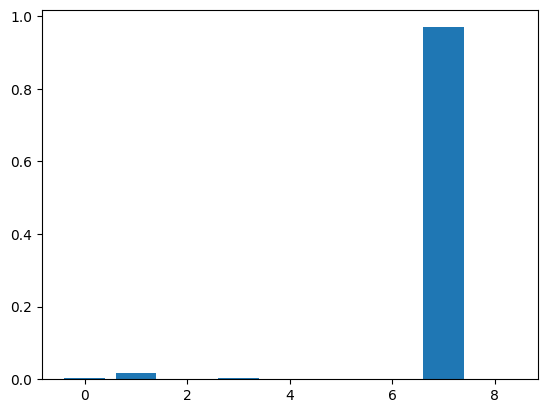

In [26]:
game = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = game.get_initial_state()
state = game.get_next_state(state, 2, -1)
state = game.get_next_state(state, 4, -1)
state = game.get_next_state(state, 6, 1)
state = game.get_next_state(state, 8, 1)


encoded_state = game.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(game, 4, 64, 3, device=device)
model.load_state_dict(torch.load('model/model_3_TicTacToe.pt', map_location=device))
# model = ResNet(game, 9, 128, 3, device=device)
# model.load_state_dict(torch.load('model/model_1_ConnectFour.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(game.action_size), policy)
plt.show()

In [25]:
from IPython.display import clear_output

game = TicTacToe()
player = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = {
    'C': 2,
    'num_searches': 100,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.0,
    'dirichlet_alpha': 0.3

}

model = ResNet(game, 4, 64, 3, device)
#model.load_state_dict(torch.load("model/model_3_TicTacToe.pt", map_location=device))
#model = ResNet(game, 9, 128, device)
#model.load_state_dict(torch.load("model/model_1_ConnectFour.pt", map_location=device))

# model = ResNet(game, 12, 256, 18, device)
#model.load_state_dict(torch.load("model/model_0_Chess.pt", map_location=device))
model.load_state_dict(torch.load("model/model_2_TicTacToe.pt", map_location=device))
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()


while True:
    
    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print("valid_moves", [i for i in range(game.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))
        clear_output()

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = game.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    
    state = game.get_next_state(state, action, player)
    print(state)
    value, is_terminal = game.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = game.get_opponent(player)


[[ 1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]]
[[ 1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]]
draw
